# 1. Face Extraction Using MTCNN
This notebook uses [Pytorch's MTCNN](https://pypi.org/project/facenet-pytorch/) face detector to extract the faces from the images.

## Prerequisites
Install the pytorch's facenet library using
```
!pip install facenet-pytorch
```


In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import time
import cv2
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw

from facenet_pytorch import MTCNN, extract_face
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision import utils, transforms

import preprocessor
import viz
import configuration
import customdataset
import transformers
import enums
import featureextractors
from utilmethods import create_output_folders, check_torch_mps_device, make_torch_deterministic

device = 'cpu'
preproc = preprocessor.PreProcessor()
config = configuration.Configuration()
face_config = configuration.FaceConfig(config)
pose_config = configuration.PoseConfig(config)
vizualizer = viz.Vizualizer()

In [17]:
# Create annotation files - run just once.
# make_torch_deterministic(42)
check_torch_mps_device()

tensor([1.], device='mps:0')


In [35]:
%%time
# Extract face from each image.
def extract_faces():
    face_extractor = featureextractors.FaceExtractor(config, tqdm)
    # face_extractor.extract_faces(face_config.FEATURES_FOLDER, face_config.FACE_SUMMARY_NAME, config.ANNOTATION_FILE)
    face_extractor.extract_faces(f'{config.OUTPUT_FOLDER}/tt', face_config.FACE_SUMMARY_NAME, f'{config.OUTPUT_FOLDER}/tt/annotated.csv', limit=10)
extract_faces()

Processing img_3298.jpg: : 11it [00:01,  6.37it/s]                                                                                                                                          

CPU times: user 9.29 s, sys: 734 ms, total: 10 s
Wall time: 1.79 s


In [31]:
def summary(summary_csv):
    df_summary = pd.read_csv(summary_csv)
    df_summary['class_name'] = df_summary['class'].map(config.class_dict)
    df_0 = df_summary[df_summary['num_faces'] == 0].groupby('class_name')['img'].count()
    df_gt_1 = df_summary[df_summary['num_faces'] > 1].groupby('class_name')['img'].count()
    df_1 = df_summary[df_summary['num_faces'] == 1].groupby('class_name')['img'].count()
    
    fig, axes = plt.subplots(nrows=1, ncols=3)
    
    df_0.plot(ax=axes[0], kind='bar', title='Images With 0 Faces',
               ylabel='No. Of Images', figsize=(10, 6))

    df_gt_1.plot(ax=axes[1], kind='bar', title='Images With More Than 1 Faces', figsize=(10, 6))
    
    df_1.plot(ax=axes[2], kind='bar', title='Images With Exactly 1 Face', figsize=(10, 6))
    plt.show()
    
summary(f'{face_config.FEATURES_FOLDER}/{face_config.FACE_SUMMARY_NAME}')

KeyError: 'Column not found: img'

In [36]:
def visualize_stack(in_stack, title, rows=5, fixed_range=False):
    # set the number of levels
    num_levels = len(in_stack)
    cols = num_levels // rows
    cols = cols + 1 if num_levels % rows > 0 else cols
    
    # create multi-row figure
    fig, axes = plt.subplots(rows, cols, figsize=[12, 8], dpi=72)

    # add images to the figure from the stack
    # don't forget to set the cmap, vmin, vmax, and axis off
    # add titles to the plot
    for i, image in enumerate(in_stack):
        if rows > 1 and cols > 1:
            col = i % cols
            row = i // cols
            axis = axes[row, col]
        else:
            axis = axes[i]
        img = in_stack[i]
        if fixed_range:
            axis.imshow(in_stack[i], cmap='gray', vmin=0., vmax=1.)
        else:
            axis.imshow(in_stack[i], cmap='gray')
        axis.axis('off')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def sample_and_display(dataloader, image_extractor, count, title, rows=5):
    stack = []
    for batch_idx, samples in enumerate(dataloader):
        if batch_idx >= count:
            break
        image = image_extractor(samples)
        stack.append(image)
    visualize_stack(stack, title, rows=rows)
    
def sample_and_display_faces(dataloader, count, title, rows=5):
    faces_stack = []
    annotated_stack = []
    for batch_idx, samples in enumerate(dataloader):
        if batch_idx >= count:
            break
        images, _, _ = samples
        # print(f'images:{images}')
        faces_stack.append(images[enums.ImageTypes.JUST_FACES])
        annotated_stack.append(images[enums.ImageTypes.ANNOTATED_WITH_FACES])
    visualize_stack(faces_stack, f'{title}-faces', rows=rows)
    visualize_stack(annotated_stack, f'{title}-annotated', rows=rows)    

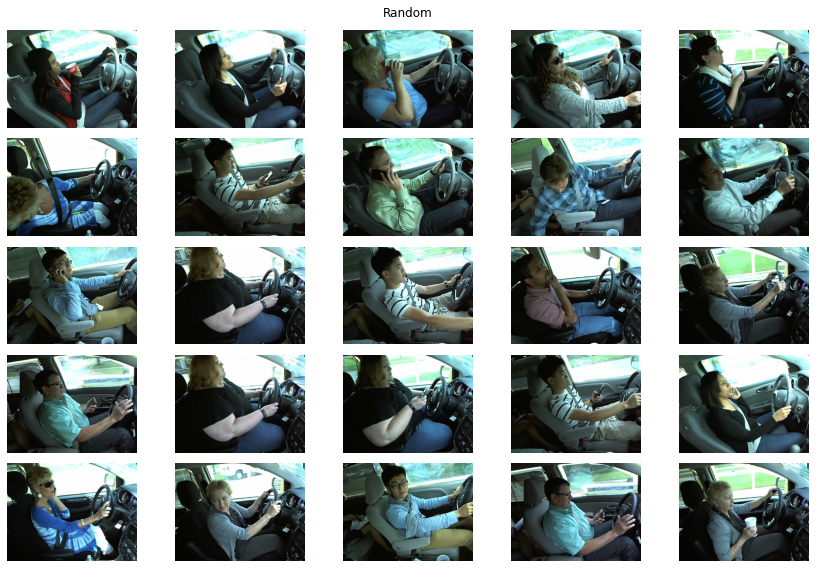

In [37]:
def random_originals():
    t = transforms.Compose([transformers.PyTorchImageToNPArray()])
    dataset = customdataset.OriginalDataset(config, transform=t)
    dataloader = DataLoader(dataset, num_workers=0, batch_size=1, shuffle=True, collate_fn=dataset.get_image_from)
    sample_and_display(dataloader, lambda x: x[0], 25, 'Random')

random_originals()


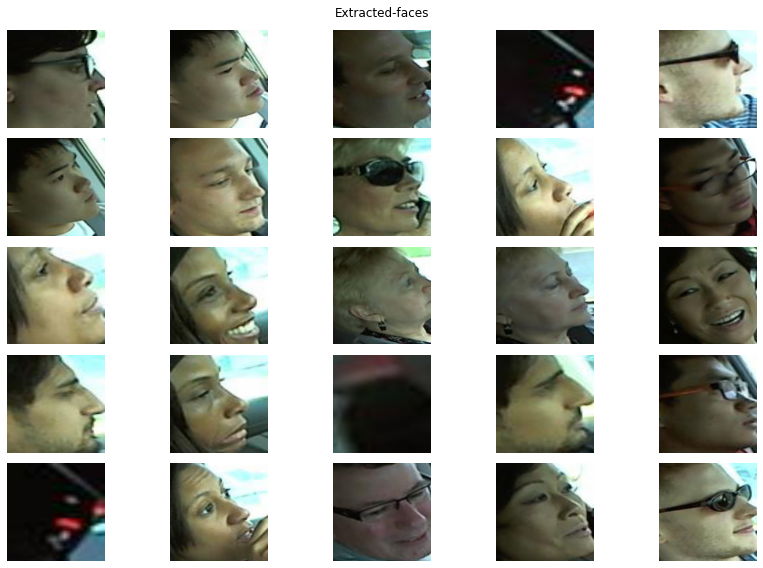

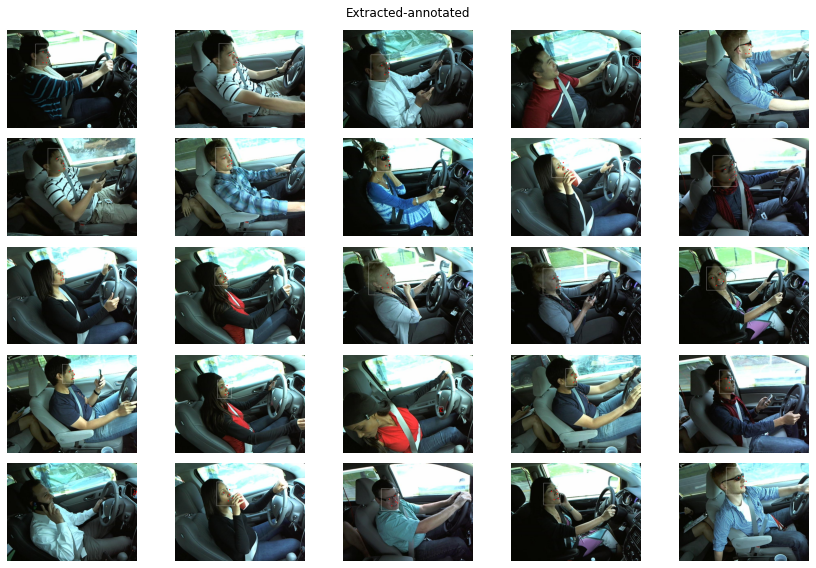

In [38]:
def sample_faces(random=True):
    t = {enums.ImageTypes.JUST_FACES: transforms.Compose([transformers.PyTorchImageToNPArray()])}
    # config, face_config, pose_config, image_types=None, transformers=None, label=None, should_load_images=True
    image_types = [enums.ImageTypes.JUST_FACES, enums.ImageTypes.ANNOTATED_WITH_FACES]
    dataset = customdataset.MainDataset(config, face_config, pose_config, transformers=t, image_types=image_types)
    
    if random:
        dataloader = DataLoader(dataset, num_workers=0, batch_size=1, 
                                shuffle=True, collate_fn=dataset.get_image_from)
    else:
        make_torch_deterministic(config.SEED)
        def seed_worker(worker_id):
            worker_seed = torch.initial_seed() % 2**32
            numpy.random.seed(worker_seed)
            random.seed(worker_seed)

        g = torch.Generator()
        g.manual_seed(config.SEED)
        dataloader = DataLoader(dataset, num_workers=0, batch_size=1, 
                                shuffle=True, collate_fn=dataset.get_image_from,
                                worker_init_fn=seed_worker, generator=g)
        
    sample_and_display_faces(dataloader, 25, 'Extracted', rows=5)

sample_faces(random=False)


In [22]:
# help(MTCNN)